## CSGO

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from collections import Counter

conn = psycopg2.connect(database="test", user="postgres", password="0000", host="localhost", port="5432")

### Data preprocessing

In [2]:
# Import data
df = pd.read_sql("SELECT * FROM csgo.profiles", conn)
df_weaponstats = pd.read_sql("SELECT * FROM csgo.weapons_stats", conn)

# Drop values that shouldn't be NaN for normal players
df = df.dropna(subset=['total_kills','total_deaths','total_time_played','total_rounds_played',
                                             'total_shots_fired'])
# Fill NaN
df.fillna(0, inplace=True)

# Add Kill Death Ratio
df['kill_death_ratio'] = df['total_kills'].div(df['total_deaths'] ,axis='index')
df['headshot_ratio'] = df['total_kills_headshot'].div(df['total_kills'] ,axis='index')
df['accuracy'] = df['total_shots_hit'].div(df['total_shots_fired'] ,axis='index')
df['win_rate'] = df['total_wins'].div(df['total_rounds_played'] ,axis='index')
df['mvp_percentage'] = df['total_mvps'].div(df['total_rounds_played'] ,axis='index')
#df['kills_per_round'] = df['total_kills'].div(df['total_rounds_played'] ,axis='index')
#df['death_per_round'] = df['total_deaths'].div(df['total_rounds_played'] ,axis='index')

# Exclude unreasonable data
df = df[(df['total_time_played'] != 0) & (df['total_shots_fired'] != 0) & (df['total_deaths'] != 0) & (df['total_kills'] != 0) &
        (df['total_shots_fired']>df['total_kills']) & (df['total_kills_headshot']<df['total_kills']) &  
        (df['total_time_played'] <= 1963*12*60*60) & (df['total_mvps']<df['total_rounds_played']) & 
        (df['total_deaths']<1963*12*30) & (df['total_kills']<df['total_rounds_played']*9) & (df['kill_death_ratio']<=15) & 
        (df['win_rate']<1) & (df['accuracy']<1)]

df_test = df

# Game released in 21Aug2013, the latest updated profile in data is 5Jan2018, game hours played should not exceed 1963 days
# Total MVP should be less than total rounds played
# Max game round per hour is 30, total death should not exceed 1963days*12hour*30rounds
# Exclude more than 9 kills per round
# Exclude Kill Death ratio exceed 15

df = df.drop(['nickname','steam_id','about','updated_at','compensation',
              'total_kills_headshot','total_kills','total_deaths','total_wins','total_rounds_played',
              'total_shots_fired','total_shots_hit'],axis=1)

df = df.set_index('user_id')

## Correlation

In [3]:
df_corr = df_test[['rank_id','total_time_played','total_mvps','kill_death_ratio','headshot_ratio','accuracy',
               'win_rate','mvp_percentage','total_kills_headshot','total_kills','total_deaths','total_wins',
               'total_rounds_played', 'total_shots_fired','total_shots_hit']].copy()
corr = df_corr.corr()
df_corr.corr()

,rank_id,total_time_played,total_mvps,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage,total_kills_headshot,total_kills,total_deaths,total_wins,total_rounds_played,total_shots_fired,total_shots_hit
rank_id,1.000000,0.503628,0.429757,0.186075,0.465744,0.165440,0.147835,0.171853,0.473510,0.497598,0.474077,0.491430,0.066824,0.042500,0.014678
total_time_played,0.503628,1.000000,0.648009,0.008187,0.254067,0.017225,-0.001590,-0.021629,0.767316,0.827430,0.843160,0.806926,0.102280,0.071072,0.021901
total_mvps,0.429757,0.648009,1.000000,0.129684,0.248745,0.108116,0.025623,0.251762,0.700260,0.720608,0.634015,0.697978,0.095119,0.080508,0.052587
kill_death_ratio,0.186075,0.008187,0.129684,1.000000,0.167003,0.444636,0.478340,0.453975,0.169277,0.149944,-0.047974,0.065172,0.069406,0.012147,0.013112
headshot_ratio,0.465744,0.254067,0.248745,0.167003,1.000000,0.104303,0.017652,0.234594,0.442644,0.261809,0.236148,0.245825,0.045126,0.039233,0.023004
accuracy,0.165440,0.017225,0.108116,0.444636,0.104303,1.000000,0.196469,0.339498,0.132917,0.130830,0.045788,0.041068,0.071819,0.074798,0.079859
win_rate,0.147835,-0.001590,0.025623,0.478340,0.017652,0.196469,1.000000,0.309358,0.053287,0.070707,-0.013016,0.067008,-0.034081,-0.009011,-0.009252
mvp_percentage,0.171853,-0.021629,0.251762,0.453975,0.234594,0.339498,0.309358,1.000000,0.096401,0.082487,0.004412,0.033786,-0.008054,0.001157,0.001925
total_kills_headshot,0.473510,0.767316,0.700260,0.169277,0.442644,0.132917,0.053287,0.096401,1.000000,0.922745,0.826709,0.727074,0.179543,0.085550,0.040651
total_kills,0.497598,0.827430,0.720608,0.149944,0.261809,0.130830,0.070707,0.082487,0.922745,1.000000,0.927157,0.782094,0.158031,0.079543,0.031612


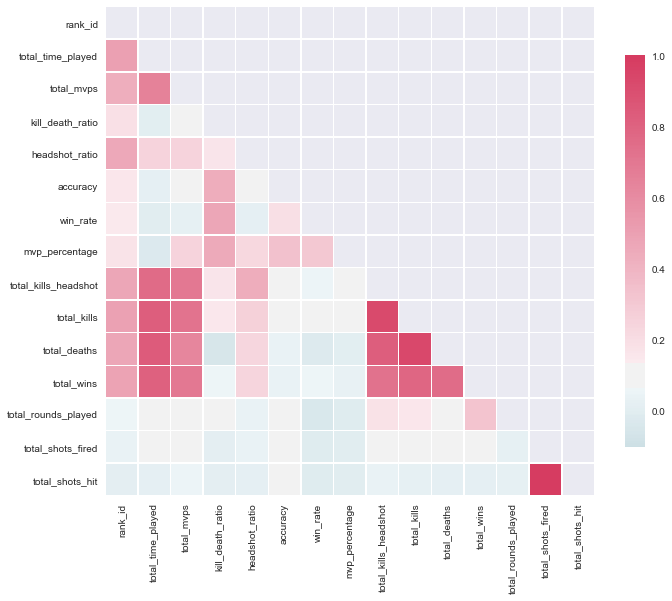

In [4]:
sns.set()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 3, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-0.1 ,vmax=1, center=0.1,
            square=True, linewidths=.5, cbar_kws={"shrink": .8})

#plt.savefig('corrall.png')
plt.show()

## PCA

In [5]:
df_kmeans = df.drop(['rank_id','total_time_played','total_mvps','goal_id'],axis=1)
df_kmeans = df_kmeans.reset_index(drop=True)
df_target = df[['rank_id']].reset_index(drop=True)
df_kmeans.head()

,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
0,0.111111,0.000000,0.727273,0.125000,0.000000
1,0.793251,0.308351,0.176158,0.507693,0.069118
2,0.901163,0.274194,0.174500,0.549020,0.000000
3,0.745455,0.292683,0.107234,0.550000,0.112500
4,0.778298,0.299179,0.217408,0.484754,0.152347


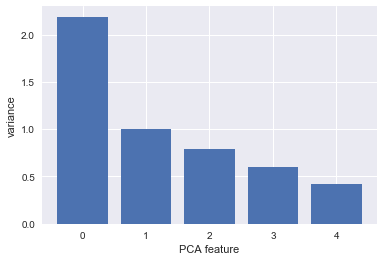

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)


pipeline.fit(df_kmeans.values)

features = range(pca.n_components_)
sns.set()
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [7]:
pca = PCA(n_components=2)
pca.fit(df_kmeans.values)

pca_features = pca.transform(df_kmeans.values)
print(pca_features.shape)

(74569, 2)


In [8]:
pca_features_rank = pd.DataFrame(data = pca_features, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([pca_features_rank, df_target], axis = 1)

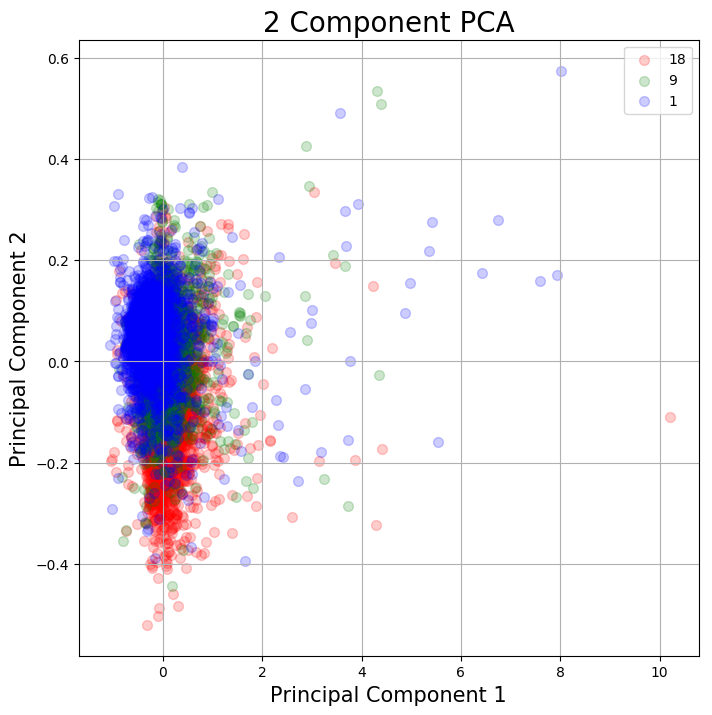

In [9]:
plt.rcdefaults()
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)
targets = [18,9,1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['rank_id'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50, alpha = 0.2)

ax.grid()
ax.legend(targets)
plt.show()

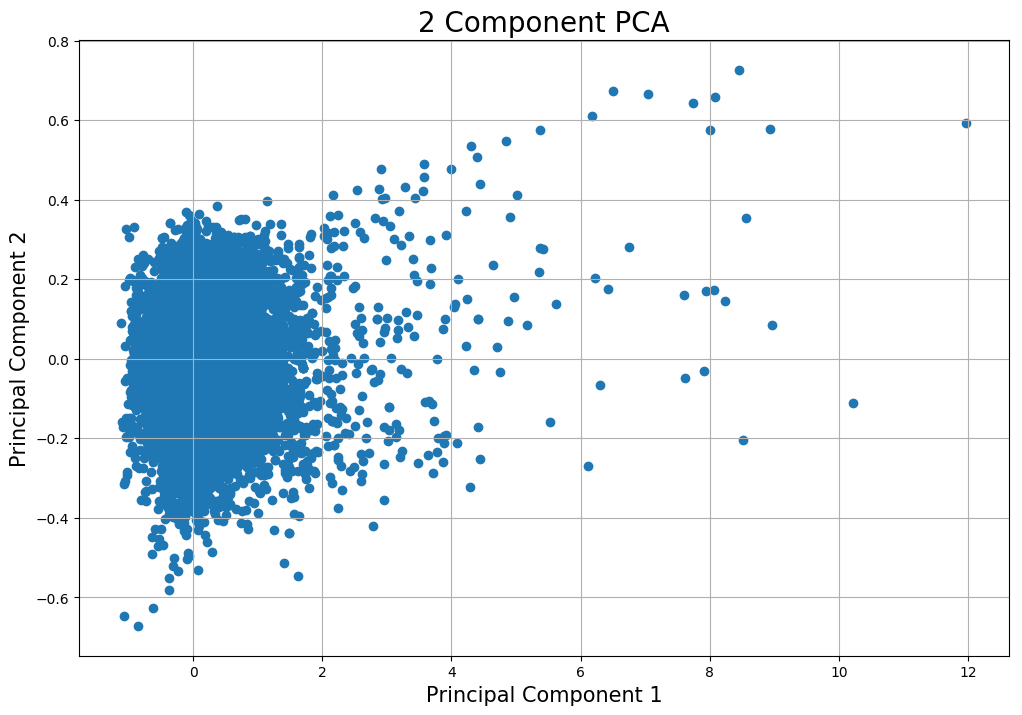

In [10]:
fig = plt.figure(figsize = (12,8))
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 Component PCA', fontsize = 20)
plt.scatter(pca_features[:,0], pca_features[:,1])
plt.grid()
plt.show()

In [11]:
finalDf_all = pd.concat([finalDf, df_kmeans], axis = 1)

Principal Component 1 presents the difference of kd-ratio
Dots with value over than 2 on Principal Component 1 has unsual high kill-death ratio

In [12]:
finalDf_all[finalDf_all['principal component 1']>2].describe()

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,3.534663,0.070942,9.960526,4.609267,0.467233,0.276576,0.612318,0.255655
std,1.761147,0.250977,5.168800,1.771248,0.237195,0.100428,0.154861,0.160367
min,2.008029,-0.421288,1.000000,3.082864,0.000000,0.119675,0.014181,0.000024
25%,2.295060,-0.150712,7.000000,3.365527,0.268141,0.213401,0.513918,0.138205
50%,2.955050,0.062178,10.000000,4.017383,0.475910,0.261595,0.588890,0.216441
75%,3.916372,0.249123,14.000000,4.988095,0.657912,0.302408,0.714504,0.351981
max,11.971170,0.726932,18.000000,13.111460,0.998323,0.997726,0.999708,0.785714


In [13]:
finalDf_all[finalDf_all['principal component 1']<2].describe()

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
count,74341.000000,74341.000000,74341.000000,74341.000000,74341.000000,74341.000000,74341.000000,74341.000000
mean,-0.010841,-0.000218,10.855611,1.063560,0.371875,0.185580,0.508467,0.129205
std,0.273241,0.090284,4.735279,0.270090,0.091310,0.029140,0.055716,0.042808
min,-1.110139,-0.671207,1.000000,0.000675,0.000000,0.029786,0.000000,0.000000
25%,-0.164139,-0.052894,7.000000,0.911984,0.310172,0.167474,0.488500,0.102417
50%,-0.040255,0.007008,11.000000,1.034671,0.363643,0.184365,0.502182,0.122796
75%,0.099829,0.059013,15.000000,1.172674,0.425414,0.202294,0.517383,0.148943
max,1.995246,0.397141,18.000000,3.078237,0.991240,0.994746,0.998289,0.983967


Principal Component 2 presents the difference of headshot ratio
Rank18 shows higher number of poeple with higher headshot raio compared to lower ranks

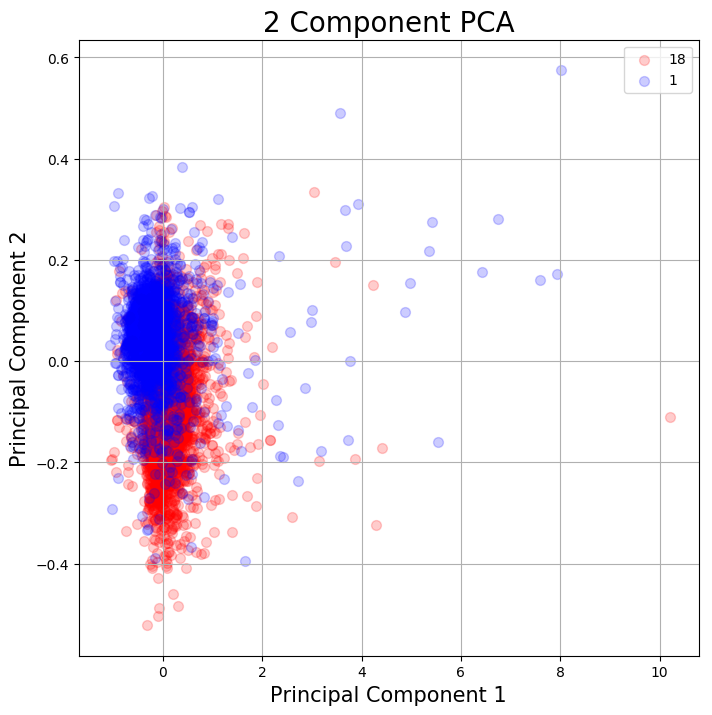

In [14]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)
targets = [18,1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['rank_id'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50, alpha = 0.2)
ax.grid()
ax.legend(targets)
plt.show()

In [15]:
finalDf_all[finalDf_all['principal component 2']<-0.2].describe()

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
count,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000,1779.000000
mean,0.138586,-0.256913,14.775717,1.199516,0.634904,0.195973,0.510413,0.152459
std,0.625595,0.057235,3.865535,0.624877,0.065288,0.052039,0.066776,0.060803
min,-1.077289,-0.671207,1.000000,0.006268,0.515547,0.064286,0.002437,0.000000
25%,-0.163614,-0.279002,13.000000,0.896894,0.589612,0.169357,0.495064,0.114855
50%,0.001200,-0.239569,16.000000,1.063519,0.614295,0.189030,0.508320,0.140413
75%,0.227386,-0.216702,18.000000,1.288719,0.662236,0.209422,0.526070,0.173837
max,8.514126,-0.200018,18.000000,9.619438,0.996327,0.994746,0.970224,0.687190


In [16]:
finalDf_all[finalDf_all['principal component 2']>-0.2].describe()

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
count,72790.000000,72790.000000,72790.000000,72790.000000,72790.000000,72790.000000,72790.000000,72790.000000
mean,-0.003387,0.006279,10.757000,1.071344,0.365746,0.185611,0.508745,0.129032
std,0.339320,0.082490,4.715526,0.337071,0.082985,0.029255,0.056302,0.043569
min,-1.110139,-0.199998,1.000000,0.000675,0.000000,0.029786,0.000000,0.000000
25%,-0.163640,-0.047706,7.000000,0.912878,0.308842,0.167474,0.488373,0.102205
50%,-0.040216,0.009553,11.000000,1.034867,0.361112,0.184342,0.502089,0.122539
75%,0.099466,0.060477,15.000000,1.172667,0.420299,0.202314,0.517302,0.148556
max,11.971170,0.726932,18.000000,13.111460,0.998323,0.997726,0.999708,0.983967


# KMeans

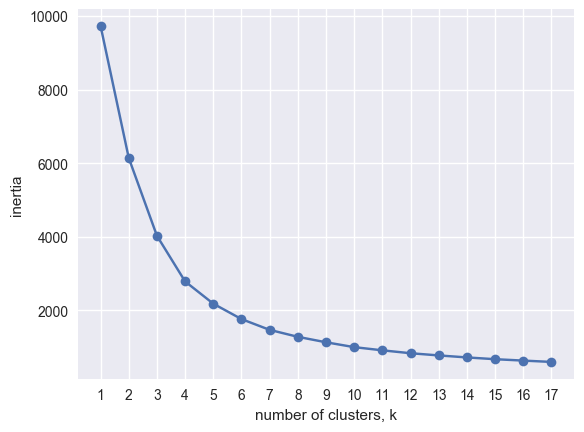

In [17]:
from sklearn.cluster import KMeans
ks = range(1, 18)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(pca_features)  
    inertias.append(model.inertia_)  

sns.set()
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [18]:
finalDf_all = pd.concat([finalDf, df_kmeans], axis = 1)
finalDf_all.head()

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
0,-0.991493,0.306517,1,0.111111,0.000000,0.727273,0.125000,0.000000
1,-0.286288,0.055184,11,0.793251,0.308351,0.176158,0.507693,0.069118
2,-0.181572,0.102921,1,0.901163,0.274194,0.174500,0.549020,0.000000
3,-0.331279,0.067707,1,0.745455,0.292683,0.107234,0.550000,0.112500
4,-0.296921,0.054332,8,0.778298,0.299179,0.217408,0.484754,0.152347


In [19]:
finalDf_all[finalDf_all['principal component 1']>2].describe()

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
count,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000,228.000000
mean,3.534663,0.070942,9.960526,4.609267,0.467233,0.276576,0.612318,0.255655
std,1.761147,0.250977,5.168800,1.771248,0.237195,0.100428,0.154861,0.160367
min,2.008029,-0.421288,1.000000,3.082864,0.000000,0.119675,0.014181,0.000024
25%,2.295060,-0.150712,7.000000,3.365527,0.268141,0.213401,0.513918,0.138205
50%,2.955050,0.062178,10.000000,4.017383,0.475910,0.261595,0.588890,0.216441
75%,3.916372,0.249123,14.000000,4.988095,0.657912,0.302408,0.714504,0.351981
max,11.971170,0.726932,18.000000,13.111460,0.998323,0.997726,0.999708,0.785714


In [20]:
finalDf_all[finalDf_all['principal component 1']<2].describe()

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
count,74341.000000,74341.000000,74341.000000,74341.000000,74341.000000,74341.000000,74341.000000,74341.000000
mean,-0.010841,-0.000218,10.855611,1.063560,0.371875,0.185580,0.508467,0.129205
std,0.273241,0.090284,4.735279,0.270090,0.091310,0.029140,0.055716,0.042808
min,-1.110139,-0.671207,1.000000,0.000675,0.000000,0.029786,0.000000,0.000000
25%,-0.164139,-0.052894,7.000000,0.911984,0.310172,0.167474,0.488500,0.102417
50%,-0.040255,0.007008,11.000000,1.034671,0.363643,0.184365,0.502182,0.122796
75%,0.099829,0.059013,15.000000,1.172674,0.425414,0.202294,0.517383,0.148943
max,1.995246,0.397141,18.000000,3.078237,0.991240,0.994746,0.998289,0.983967


In [21]:
finalDf_all[finalDf_all['principal component 1']>2].head(20)

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
147,3.204868,-0.245846,17,4.274295,0.774758,0.395702,0.507441,0.119788
291,2.307776,-0.041131,15,3.386763,0.523331,0.232503,0.509884,0.162224
558,8.009113,0.574164,1,9.100000,0.175824,0.446753,0.780488,0.390244
788,3.168994,0.097658,15,4.237753,0.416829,0.231135,0.644212,0.340442
1243,4.237691,0.149944,18,5.306801,0.414834,0.434938,0.639820,0.330626
1245,2.064281,0.066256,10,3.136388,0.400223,0.221875,0.592549,0.246084
1343,2.074925,0.301529,6,3.176664,0.173402,0.198180,0.484018,0.090346
1825,2.311595,-0.125840,1,3.375000,0.592593,0.170431,0.545455,0.363636
1861,3.885337,-0.210904,13,4.965698,0.776581,0.310281,0.493270,0.086325
2180,2.129467,0.176904,10,3.202832,0.317165,0.247296,0.752846,0.066667


In [22]:
finalDf_all[finalDf_all['principal component 2']<-0.3].head()

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
1118,0.075998,-0.301884,17,1.135792,0.677830,0.174477,0.509008,0.145831
1341,1.134570,-0.327391,13,2.182927,0.754190,0.258778,0.611111,0.206349
1887,-0.489342,-0.427733,5,0.567601,0.781406,0.105202,0.503024,0.099130
2031,-0.173420,-0.379699,13,0.886275,0.747142,0.147071,0.492177,0.103529
2063,0.145486,-0.304530,17,1.195177,0.675441,0.208172,0.546898,0.253763


In [23]:
finalDf_all[finalDf_all['principal component 2']<-0.3].describe()

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
count,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000,307.000000
mean,0.140266,-0.356873,14.693811,1.197180,0.734710,0.204070,0.497823,0.151610
std,0.637189,0.058955,4.336808,0.634901,0.064876,0.091991,0.099413,0.064140
min,-1.077289,-0.671207,1.000000,0.006268,0.596836,0.092424,0.002437,0.000000
25%,-0.194261,-0.376764,13.000000,0.864324,0.688720,0.164284,0.490809,0.114218
50%,0.023569,-0.337962,16.000000,1.079983,0.718555,0.184901,0.504419,0.135833
75%,0.264999,-0.316738,18.000000,1.327548,0.761985,0.211888,0.523925,0.172735
max,4.283604,-0.300132,18.000000,5.359184,0.991240,0.994746,0.964472,0.461705


In [24]:
finalDf_all[finalDf_all['principal component 2']>-0.3].describe()

,principal component 1,principal component 2,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage
count,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000,74262.000000
mean,-0.000580,0.001475,10.836996,1.073894,0.370668,0.185783,0.508830,0.129500
std,0.347769,0.088459,4.732029,0.345505,0.089349,0.029496,0.056326,0.044080
min,-1.110139,-0.299388,1.000000,0.000675,0.000000,0.029786,0.000000,0.000000
25%,-0.163558,-0.052137,7.000000,0.912649,0.309889,0.167525,0.488527,0.102398
50%,-0.039598,0.007452,11.000000,1.035278,0.363340,0.184450,0.502221,0.122828
75%,0.100996,0.059424,15.000000,1.173898,0.424757,0.202435,0.517468,0.149065
max,11.971170,0.726932,18.000000,13.111460,0.998323,0.997726,0.999708,0.983967


In [25]:
from sklearn.cluster import KMeans
num_clusters = 3
model = KMeans(n_clusters=num_clusters)
model.fit(pca_features)  

clusters = model.labels_

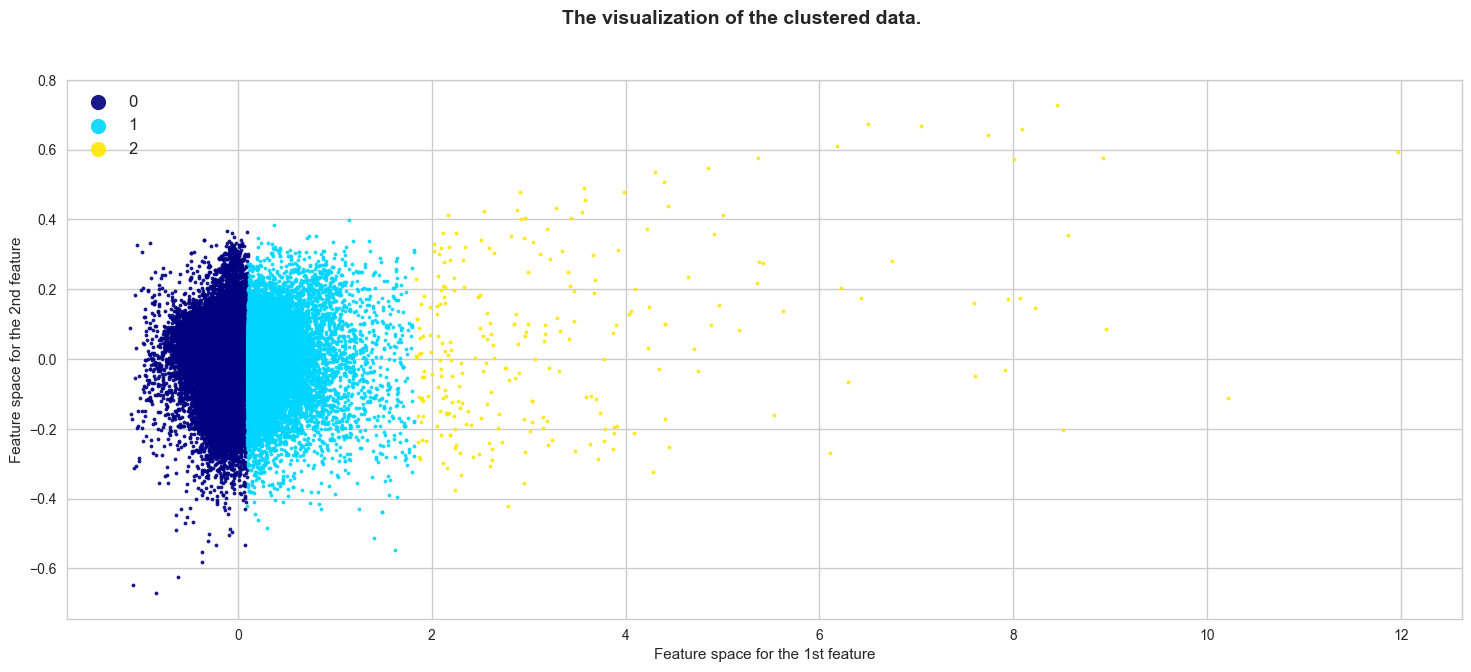

In [44]:
X = pca_features

df_plot = pd.DataFrame({'x': X[:,0], 'y': X[:,1], 'cluster': clusters})

fig, ax = plt.subplots()
fig.set_size_inches(18, 7)

cmap = plt.cm.get_cmap('jet')
for i, cluster in df_plot.groupby('cluster'):
    _ = ax.scatter(cluster['x'], cluster['y'], c=cmap(i/num_clusters), label=i, marker='.', s=30, lw=0, alpha=0.9, edgecolor='k')

sns.set_style('whitegrid', {'axes.grid' : True})
ax.set_title("")
ax.set_xlabel("Feature space for the 1st feature")
ax.set_ylabel("Feature space for the 2nd feature")
ax.legend(fontsize = 12, markerscale = 4, loc = "best")

plt.suptitle("The visualization of the clustered data.", fontsize=14, fontweight='bold')

plt.show()

# Linear Regression with "profile" and "weapon" table

In [27]:
df_weaponstats.head()

,user_id,weapon_name,total_kills,total_hits,total_shots
0,49773,deagle,1595,4221,23008
1,49773,hkp2000,1515,6061,37673
2,49773,glock,1391,6271,44151
3,49773,ak47,9931,38327,275239
4,49773,m4a1,3937,16831,104204


In [28]:
df_weaponstats = pd.read_sql("SELECT * FROM csgo.weapons_stats", conn)
df_mw = df_weaponstats.sort_values('user_id',ascending=True).reset_index(drop=True)
df_mw = df_mw[(df_mw['weapon_name']=='ak47') | (df_mw['weapon_name']=='m4a1') | (df_mw['weapon_name']=='awp') ]
df_mw.head()

,user_id,weapon_name,total_kills,total_hits,total_shots
2,2,m4a1,8141,32443,143515
3,2,ak47,9835,33491,185657
8,2,awp,10102,11266,28096
11,4,m4a1,254,987,5760
13,4,awp,63,76,200


In [29]:
df_mwt = df_mw.groupby(df_mw["user_id"]).sum()
df_mwt['main_weapons_accuracy'] = df_mwt['total_hits'].div(df_mwt['total_shots'] ,axis='index')
df_mwt['kill_hit_ratio'] = df_mwt['total_kills'].div(df_mwt['total_hits'] ,axis='index')
df_mwt['kill_shot_ratio'] = df_mwt['total_kills'].div(df_mwt['total_shots'] ,axis='index')
df_mwt.head()

,total_kills,total_hits,total_shots,main_weapons_accuracy,kill_hit_ratio,kill_shot_ratio
user_id,,,,,,
2,28078,77200,357268,0.216084,0.363705,0.078591
4,796,2665,15768,0.169013,0.298687,0.050482
6,29083,77321,325912,0.237245,0.376133,0.089236
105,55,206,1782,0.115600,0.266990,0.030864
122,1419,5047,23822,0.211863,0.281157,0.059567


In [30]:
df_ma = df_mw[(df_mw['weapon_name']=='ak47') | (df_mw['weapon_name']=='m4a1')]
df_ma = df_ma.groupby(df_ma["user_id"]).sum()
df_ma['assault_accuracy'] = df_ma['total_hits'].div(df_ma['total_shots'] ,axis='index')
df_ma['assault_kill_hit_ratio'] = df_ma['total_kills'].div(df_ma['total_hits'] ,axis='index')
df_ma['assault_kill_shot_ratio'] = df_ma['total_kills'].div(df_ma['total_shots'] ,axis='index')
df_ma.head()

,total_kills,total_hits,total_shots,assault_accuracy,assault_kill_hit_ratio,assault_kill_shot_ratio
user_id,,,,,,
2,17976,65934,329172,0.200303,0.272636,0.054610
4,733,2589,15568,0.166303,0.283121,0.047084
6,19444,66560,298980,0.222624,0.292127,0.065034
105,48,199,1759,0.113132,0.241206,0.027288
122,1355,4975,23662,0.210253,0.272362,0.057265


In [31]:
df_ms = df_mw[(df_mw['weapon_name']=='awp')]
df_ms = df_ms.groupby(df_ms["user_id"]).sum()
df_ms['sniper_accuracy'] = df_ms['total_hits'].div(df_ms['total_shots'] ,axis='index')
df_ms['sniper_kill_hit_ratio'] = df_ms['total_kills'].div(df_ms['total_hits'] ,axis='index')
df_ms['sniper_kill_shot_ratio'] = df_ms['total_kills'].div(df_ms['total_shots'] ,axis='index')
df_ms['sniper_usage']= df_ms['total_kills'].div(df_mwt['total_kills'] ,axis='index')
df_ms.head(5)

,total_kills,total_hits,total_shots,sniper_accuracy,sniper_kill_hit_ratio,sniper_kill_shot_ratio,sniper_usage
user_id,,,,,,,
2,10102,11266,28096,0.400982,0.896680,0.359553,0.359783
4,63,76,200,0.380000,0.828947,0.315000,0.079146
6,9639,10761,26932,0.399562,0.895735,0.357901,0.331431
105,7,7,23,0.304348,1.000000,0.304348,0.127273
122,64,72,160,0.450000,0.888889,0.400000,0.045102


In [32]:
df_1 = df_ma.drop(['total_kills','total_hits','total_shots'],axis=1)
df_2 = df_ms.drop(['total_kills','total_hits','total_shots'],axis=1)
df_mwa = pd.concat([df, df_1, df_2], axis=1, join_axes=[df.index])
df_mwa = df_mwa.dropna()
df_mwa.head()

,total_time_played,total_mvps,rank_id,goal_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage,assault_accuracy,assault_kill_hit_ratio,assault_kill_shot_ratio,sniper_accuracy,sniper_kill_hit_ratio,sniper_kill_shot_ratio,sniper_usage
user_id,,,,,,,,,,,,,,,,
216,4726211.0,3122.0,11,1,0.793251,0.308351,0.176158,0.507693,0.069118,0.175034,0.272808,0.047751,0.336535,0.891732,0.300099,0.371126
154,9229.0,0.0,1,3,0.901163,0.274194,0.174500,0.549020,0.000000,0.113132,0.241206,0.027288,0.304348,1.000000,0.304348,0.127273
187,10472.0,9.0,1,1,0.745455,0.292683,0.107234,0.550000,0.112500,0.111899,0.267606,0.029945,0.200000,1.000000,0.200000,0.269231
176,2510854.0,2743.0,8,1,0.778298,0.299179,0.217408,0.484754,0.152347,0.293314,0.398715,0.116949,0.383839,0.911977,0.350052,0.320468
219,2064934.0,4814.0,8,2,1.502499,0.343808,0.166819,0.562307,0.172582,0.163594,0.281092,0.045985,0.332363,0.892766,0.296722,0.271890


In [33]:
df = df_mwa.drop(['total_time_played','total_mvps','goal_id'], axis=1)
df.head()

,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage,assault_accuracy,assault_kill_hit_ratio,assault_kill_shot_ratio,sniper_accuracy,sniper_kill_hit_ratio,sniper_kill_shot_ratio,sniper_usage
user_id,,,,,,,,,,,,,
216,11,0.793251,0.308351,0.176158,0.507693,0.069118,0.175034,0.272808,0.047751,0.336535,0.891732,0.300099,0.371126
154,1,0.901163,0.274194,0.174500,0.549020,0.000000,0.113132,0.241206,0.027288,0.304348,1.000000,0.304348,0.127273
187,1,0.745455,0.292683,0.107234,0.550000,0.112500,0.111899,0.267606,0.029945,0.200000,1.000000,0.200000,0.269231
176,8,0.778298,0.299179,0.217408,0.484754,0.152347,0.293314,0.398715,0.116949,0.383839,0.911977,0.350052,0.320468
219,8,1.502499,0.343808,0.166819,0.562307,0.172582,0.163594,0.281092,0.045985,0.332363,0.892766,0.296722,0.271890


In [34]:
df.describe()

,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage,assault_accuracy,assault_kill_hit_ratio,assault_kill_shot_ratio,sniper_accuracy,sniper_kill_hit_ratio,sniper_kill_shot_ratio,sniper_usage
count,74363.000000,74363.000000,74363.000000,74363.000000,74363.000000,74363.000000,74363.000000,74363.000000,74363.000000,74363.000000,74363.000000,74363.000000,74363.000000
mean,10.867300,1.074608,0.372222,0.185922,0.508901,0.129682,0.179080,0.287549,0.051603,0.340662,0.879305,0.300091,0.327954
std,4.728358,0.343020,0.092067,0.029768,0.056205,0.043799,0.031229,0.674739,0.111829,0.099198,0.512174,0.214198,0.136214
min,1.000000,0.000675,0.000000,0.031231,0.000000,0.000000,0.000614,0.000000,0.000000,0.008846,0.000000,0.000000,0.000000
25%,7.000000,0.913156,0.310292,0.167584,0.488612,0.102539,0.160191,0.259893,0.043338,0.298725,0.852514,0.255842,0.233904
50%,11.000000,1.035686,0.363807,0.184492,0.502251,0.122932,0.177535,0.273402,0.049050,0.337241,0.876663,0.292723,0.318801
75%,15.000000,1.174365,0.425628,0.202469,0.517493,0.149159,0.195859,0.291088,0.055345,0.378099,0.897318,0.333146,0.409814
max,18.000000,13.111460,0.998323,0.997726,0.999708,0.983967,0.867797,181.410040,29.810337,14.543396,77.944522,29.201000,1.000000


In [35]:
df = df[(df['assault_accuracy']<1) & (df['assault_kill_hit_ratio']<1) & (df['assault_kill_shot_ratio']<1) &
        (df['sniper_accuracy']<1) & (df['sniper_kill_hit_ratio']<1) & (df['sniper_kill_shot_ratio']<1) &
        (df['kill_death_ratio']<3) & (df['mvp_percentage']<0.5) & (df['headshot_ratio']<0.8) &
        (df['assault_accuracy']<0.4) & (df['assault_kill_hit_ratio']<0.6) & (df['assault_kill_shot_ratio']<0.1) &
        (df['sniper_accuracy']<0.7) &  (df['sniper_kill_shot_ratio']<0.6)]

df = df.drop(['sniper_kill_hit_ratio','assault_kill_shot_ratio'], axis=1)

In [36]:
df.describe()

,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage,assault_accuracy,assault_kill_hit_ratio,sniper_accuracy,sniper_kill_shot_ratio,sniper_usage
count,72450.000000,72450.000000,72450.000000,72450.000000,72450.000000,72450.000000,72450.000000,72450.000000,72450.000000,72450.000000,72450.000000
mean,10.874189,1.058836,0.373439,0.185330,0.507313,0.129120,0.178324,0.277341,0.339268,0.294461,0.329698
std,4.713478,0.257611,0.087932,0.027453,0.051003,0.041285,0.028091,0.033469,0.060958,0.060060,0.134303
min,1.000000,0.004064,0.025000,0.031231,0.000000,0.000000,0.032532,0.000000,0.008846,0.000000,0.000000
25%,8.000000,0.911299,0.312100,0.167488,0.488549,0.102579,0.160110,0.259690,0.298723,0.255473,0.236764
50%,11.000000,1.033153,0.364788,0.184275,0.502083,0.122787,0.177321,0.272893,0.336978,0.291752,0.320437
75%,15.000000,1.169711,0.425696,0.202037,0.516936,0.148805,0.195439,0.289718,0.377600,0.331277,0.410377
max,18.000000,2.997002,0.799942,0.757553,0.997134,0.493238,0.386804,0.596111,0.692308,0.599234,1.000000


In [37]:
df.corr()

,rank_id,kill_death_ratio,headshot_ratio,accuracy,win_rate,mvp_percentage,assault_accuracy,assault_kill_hit_ratio,sniper_accuracy,sniper_kill_shot_ratio,sniper_usage
rank_id,1.000000,0.256378,0.497015,0.175120,0.163210,0.182155,0.160444,0.238319,0.103680,0.006251,-0.239824
kill_death_ratio,0.256378,1.000000,0.183903,0.451522,0.558651,0.485127,0.408501,0.454300,0.358259,0.389631,-0.027262
headshot_ratio,0.497015,0.183903,1.000000,0.076916,0.040473,0.250741,0.070775,0.359431,0.023680,-0.051769,-0.423739
accuracy,0.175120,0.451522,0.076916,1.000000,0.200430,0.340723,0.898106,0.082026,0.722384,0.664562,-0.007968
win_rate,0.163210,0.558651,0.040473,0.200430,1.000000,0.302621,0.179855,0.371089,0.176098,0.233236,-0.029582
mvp_percentage,0.182155,0.485127,0.250741,0.340723,0.302621,1.000000,0.298160,0.250251,0.243421,0.206707,0.003330
assault_accuracy,0.160444,0.408501,0.070775,0.898106,0.179855,0.298160,1.000000,0.045832,0.665678,0.620569,-0.166347
assault_kill_hit_ratio,0.238319,0.454300,0.359431,0.082026,0.371089,0.250251,0.045832,1.000000,0.057965,0.148229,-0.087711
sniper_accuracy,0.103680,0.358259,0.023680,0.722384,0.176098,0.243421,0.665678,0.057965,1.000000,0.931848,0.058978
sniper_kill_shot_ratio,0.006251,0.389631,-0.051769,0.664562,0.233236,0.206707,0.620569,0.148229,0.931848,1.000000,0.094228


# Linear Regression on win-rate

In [38]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing, cross_validation
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
import statsmodels.tools as sm_tools

C:\Users\Jimmy\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Jimmy\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Linear Regression on all ranks

In [39]:
X = df.drop(['rank_id', 'win_rate','accuracy'], 1)
Y = df['win_rate']
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               win_rate   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     4949.
Date:                Tue, 20 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:59:28   Log-Likelihood:             1.2860e+05
No. Observations:               72450   AIC:                        -2.572e+05
Df Residuals:                   72441   BIC:                        -2.571e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

### Linear Regression rank 18

In [40]:
df18 = df[df['rank_id']==18]
X = df18.drop(['rank_id', 'win_rate','accuracy'], 1)
Y = df18['win_rate']
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               win_rate   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     320.6
Date:                Tue, 20 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:59:28   Log-Likelihood:                 9520.5
No. Observations:                5508   AIC:                        -1.902e+04
Df Residuals:                    5499   BIC:                        -1.896e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

### Linear Regression rank 12

In [41]:
df12 = df[df['rank_id']==12]
X = df12.drop(['rank_id', 'win_rate','accuracy'], 1)
Y = df12['win_rate']
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               win_rate   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     306.1
Date:                Tue, 20 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:59:28   Log-Likelihood:                 9086.5
No. Observations:                5114   AIC:                        -1.816e+04
Df Residuals:                    5105   BIC:                        -1.810e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

### Linear Regression rank 9

In [42]:
df9 = df[df['rank_id']==9]
X = df9.drop(['rank_id', 'win_rate','accuracy'], 1)
Y = df9['win_rate']
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               win_rate   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     312.1
Date:                Tue, 20 Mar 2018   Prob (F-statistic):               0.00
Time:                        11:59:28   Log-Likelihood:                 8556.5
No. Observations:                4610   AIC:                        -1.710e+04
Df Residuals:                    4601   BIC:                        -1.704e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

### Linear Regression rank 4

In [43]:
df4 = df[df['rank_id']==4]
X = df4.drop(['rank_id', 'win_rate','accuracy'], 1)
Y = df4['win_rate']
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               win_rate   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     152.5
Date:                Tue, 20 Mar 2018   Prob (F-statistic):          9.37e-205
Time:                        11:59:28   Log-Likelihood:                 4018.9
No. Observations:                2224   AIC:                            -8020.
Df Residuals:                    2215   BIC:                            -7969.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [ ]:
#df_cleaned.to_csv('data_cleaned.csv', index=False)